In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
from lkf_tools.dataset import *
import dill
import warnings
warnings.filterwarnings('ignore')

In [2]:
lkf_data = process_dataset('./data/2015/ice_2015.nc', output_path='./data/lkfs/dog005/',
                          dog_thres=0.05, t_red=1)

  -->  Compute dxu and dyu from lon,lat using SSMI projection


In [3]:
%%time
lkf_data.detect_lkfs(indexes=np.arange(10))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compute deformation rates and detect features for day 1
Start detection routines
Compute deformation rates and detect features for day 2
Start detection routines
Compute deformation rates and detect features for day 3
Start detection routines
Compute deformation rates and detect features for day 4
Start detection routines
Compute deformation rates and detect features for day 5
Start detection routines
Compute deformation rates and detect features for day 6
Start detection routines
Compute deformation rates and detect features for day 7
Start detection routines
Compute deformation rates and detect features for day 8
Start detection routines
Compute deformation rates and detect features for day 9
Start detection routines
Compute deformation rates and detect features for day 10
Start detection routines
CPU times: user 25.1 s, sys: 298 ms, total: 25.4 s
Wall time: 24.1 s


In [5]:
dill.dump(lkf_data, file = open("data/2015/lkf_pickle_files/lkf_data_2015_005.pickle", "wb"))

In [6]:
lkf_data_2015 = dill.load(open("data/2015/lkf_pickle_files/lkf_data_2015_005.pickle", "rb"))

In [7]:
lkf_data = lkf_data_2015


        parameters to adjust (ind is the timestep):
        dog_thres : threshold in the DoG filtered image for a feature to be marked as LKF (default = 0.01 units of deformation)
        min_kernel: smallest scale of features to be detected (default = 1 pixel)
        max_kernel: largest scale of features to be detected (default = 5 pixel)
                    (with this, the background deformation is calculated:
                    DoG filter = blurred image using min_kernel - blurred image using max_kernel)
        use_eps   : flag for using the total deformation (if True, default)
                    or its natural logarithm and a histogram equalization (if False)
                    (the latter highlights local differences across scales and thus enhances contrast in regions of low deformation)

        this function just creates these plots. if you want to use other values than the default ones,
        you need to adjust them in the process_dataset function when initializing the 

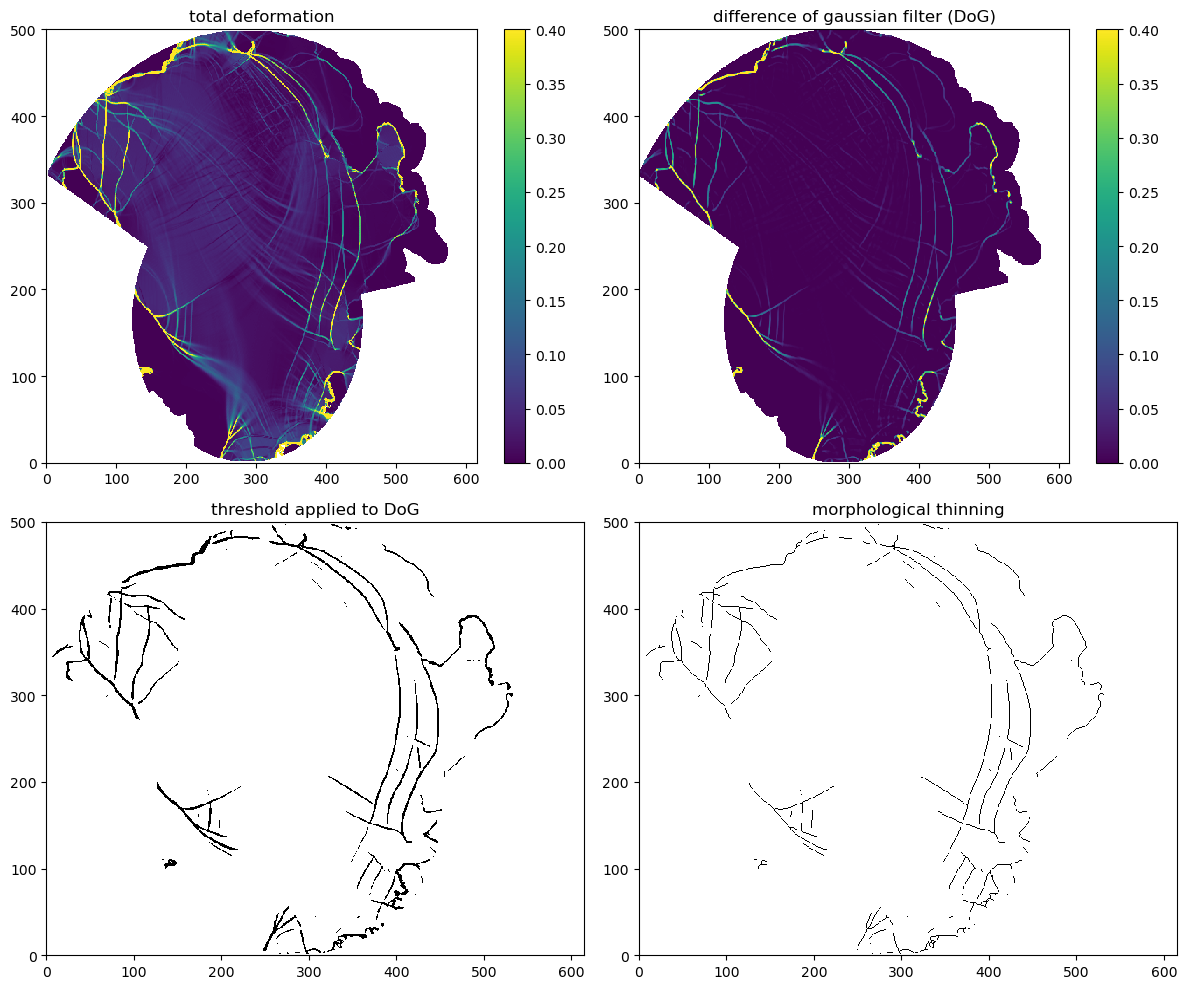

In [10]:
lkf_data.finetuning(ind=0,dog_thres=0.05)

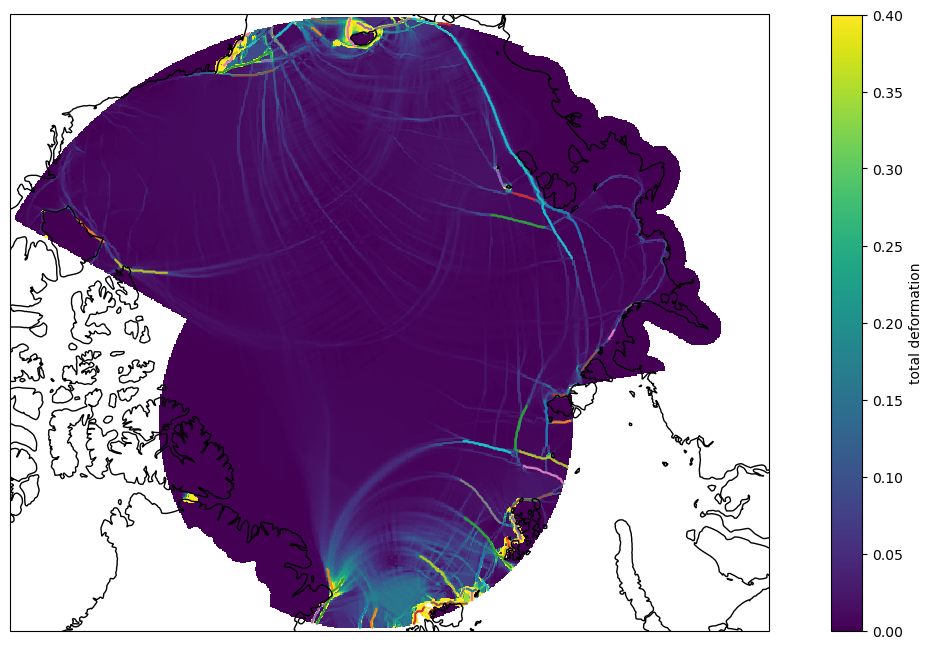

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

it = lkf_data.indexes[2]

pcm = ax.pcolormesh(lkf_data.lon[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.lat[max([0,lkf_data.index_y[0][0]-1]):lkf_data.index_y[0][-1]+2:lkf_data.red_fac,
                       max([0,lkf_data.index_x[0][0]-1]):lkf_data.index_x[0][-1]+2:lkf_data.red_fac],
              lkf_data.calc_eps_tot(it),transform=ccrs.PlateCarree(),vmin=0,vmax=0.4)

lkfs = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)

for ilkf in lkfs:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],transform=ccrs.PlateCarree())

plt.colorbar(pcm,label='total deformation')

In [12]:
%%time
lkf_data.track_lkfs(indexes=np.arange(9))

CPU times: user 1.73 ms, sys: 72 µs, total: 1.81 ms
Wall time: 1.65 ms


In [13]:
dill.dump(lkf_data, file = open("data/2015/lkf_pickle_files/lkf_data_2015_005.pickle", "wb"))

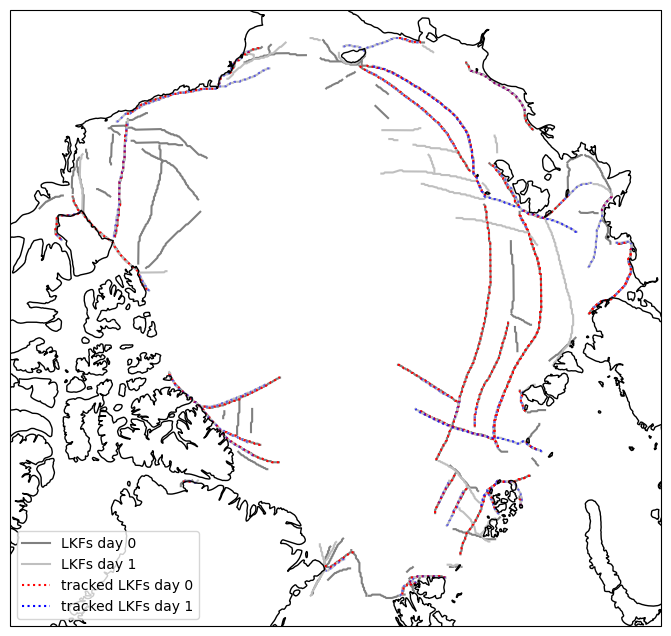

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=[16, 8])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

ax.coastlines(zorder=3)

it = 0

lkfs0 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+1))),allow_pickle=True)
lkfs1 = np.load(lkf_data.lkfpath.joinpath('lkf_%s_%03i.npy' %(lkf_data.netcdf_file.split('/')[-1].split('.')[0],(it+2))),allow_pickle=True)

tracks = np.load(lkf_data.track_output_path.joinpath('lkf_tracked_pairs_%s_to_%s.npy' %(lkf_data.lkf_filelist[it][4:-4],
                                                                                        lkf_data.lkf_filelist[it+1][4:-4])),allow_pickle=True)

for ilkf in lkfs0:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.5',transform=ccrs.PlateCarree())
    
for ilkf in lkfs1:
    if np.min(ilkf[:,2])<-150 and np.max(ilkf[:,2]>150):
        ilkf[ilkf[:,2]<0,2]+=360
    ax.plot(ilkf[:,2],ilkf[:,3],'0.75',transform=ccrs.PlateCarree())

for itrack in tracks:
    ax.plot(lkfs0[itrack[0]][:,2],lkfs0[itrack[0]][:,3],'r:',alpha=1,transform=ccrs.PlateCarree())
    ax.plot(lkfs1[itrack[1]][:,2],lkfs1[itrack[1]][:,3],'b:',alpha=0.5,transform=ccrs.PlateCarree())

    
ax.plot([0,0],[0,0],'0.5',label='LKFs day 0')
ax.plot([0,0],[0,0],'0.75',label='LKFs day 1')
ax.plot([0,0],[0,0],'r:',label='tracked LKFs day 0')
ax.plot([0,0],[0,0],'b:',label='tracked LKFs day 1')

ax.legend()